<center><img src='cs-logo.png' width=200></center>



<h6><center></center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center> Detection de points de fuite dans des images de routes </center>
<hr style=" border:none; height:3px;">
</h1>




L'objectif de ce projet est de faire un état de l'art sur les approches actuelles de détection de points de fuite et proposer une démarche particulière en utilisant les techniques de traitement d'images vues en cours .

<h1>
<hr style=" border:none; height:3px;">
<center> Cas d'usage identifié : Approximation de la reconstruction des scènes 3D afin de faciliter la navigation visuelle des voitures </center>
<hr style=" border:none; height:3px;">
</h1>

La détection du point de fuite est une technique cruciale dans le domaine de la vision par ordinateur, particulièrement dans le contexte de la navigation automobile assistée. Dans ce notebook, nous explorons comment cette technique peut être appliquée pour reconstruire des scènes en trois dimensions, facilitant ainsi la navigation visuelle des véhicules.

Dans le domaine de la conduite autonome et de la navigation assistée, les véhicules doivent être capables de comprendre leur environnement tridimensionnel pour se déplacer de manière sûre et efficace. La détection du point de fuite est l'un des outils essentiels utilisés pour obtenir une représentation tridimensionnelle de la scène à partir d'images en deux dimensions.

Nous utiliserons des techniques de traitement d'images et de vision par ordinateur pour détecter les lignes convergentes et estimer les points de fuite dans les images. En utilisant ces informations, nous essaierons d'approximer l'image à la scène 3D correspondante, en vu de nous rapprocher de la perception spatiale des véhicules autonomes et assistés.

<div style="display: flex; justify-content: center;">
    <img src='https://i.ytimg.com/vi/17D6PXB1rGQ/maxresdefault.jpg' style="margin-right: 10px;" width="400"/>
    <img src='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQpT81MSsrp7a67DOhxNqpPHXEuUU-0VsAlyw&s' style="margin-left: 10px;" width="400"/>
</div>


## **Qu'est ce que le vnp (Vanishing Point) ?**

Ici une petite intro au projet (explication du VNP, pourquoi on fait le VNP, etc)

## **Carte des données (Dataset Card)**

Nous avons considéré 2 ensembles de données pour notre projet, un premier dossier 'Set_of_images' contenant des images importés du web, et un deuxième dossier intitulé 'Road_Annotated_Dataset' qui comportait 219 images de routes annotés avec les vnp et autres classes(plus de détails sur la partie 'Aperçu Road_Annotated_Dataset').

### Aperçu Road_Annotated_Dataset

Le dataset contient un total de 219 images, réparties en différents sous-ensembles pour les besoins de l'apprentissage automatique :
- Ensemble d'entraînement : 154 images
- Ensemble de validation : 43 images
- Ensemble de test : 22 images

Chaque image est annotée avec les classes suivantes telles que définies dans le fichier `classes.csv` :
- `road-lane`
- `road-line`
- `railing`
- `background`
- **`vnp`** (Classe d'intérêt pour le projet)
- `zebra`

Les annotations présentes dans le dataset sont essentielles pour l'identification et la classification des différents éléments routiers, en particulier pour la détection du point de fuite qui est l'intérêt principal du projet.

### Accès

Le dataset est téléchargeable à l'URL suivante : [Vanishing Point and Road Detection Dataset](https://universe.roboflow.com/vanishing-point-and-road-detection/vanishingpointdetection)

Lors de la tentative de téléchargement du dataset, une fenêtre pop-up offre deux options pour le format des annotations :
- Segmentation JSON COCO
- Masques de segmentation sémantique MASK (L'option pour laquelle nous avons opté)


## **Analyse du Dataset** 

In [1]:
#Créons un chemin pour le dossier Dataset à l'aide du module os

import os
path = os.getcwd() + '\Road_Annotation_Dataset'
print(path)

c:\Users\Maamar\Desktop\VanishingPointDetection_CS\Road_Annotation_Dataset


Affichons une image et le masque correspondant :

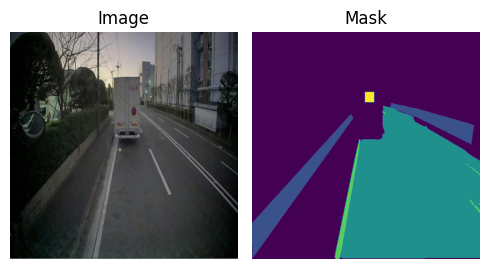

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

image_1 = Image.open('C:/Users/Maamar/Desktop/VanishingPointDetection_CS/Road_Annotated_Dataset/train/1_png.rf.21ddd5921d3c4aa880cdd9bffec1c160.jpg')
image_2 = Image.open('Road_Annotated_Dataset/train/1_png.rf.21ddd5921d3c4aa880cdd9bffec1c160_mask.png')

image_path_1 = 'C:/Users/Maamar/Desktop/VanishingPointDetection_CS/Road_Annotated_Dataset/train/1_png.rf.21ddd5921d3c4aa880cdd9bffec1c160.jpg'

fig, axes = plt.subplots(1, 2, figsize=(5, 5))

# Plot the first image
axes[0].imshow(image_1)
axes[0].axis('off')  # Hide axes for image 1
axes[0].set_title('Image') # Optional title

# Plot the second image
axes[1].imshow(image_2)
axes[1].axis('off')  # Hide axes for image 2
axes[1].set_title('Mask') # Optional title

# Display the images
plt.tight_layout()
plt.show()


# Première partie : Calcul du point de fuite

## 1. Test avec les fonctions disponibles sur OpenCV :

Calculons en un premier lieu les coordonnées du point de fuite du masque généré fourni par le dataset pour comparer avec les tentatives de calcul de nos algorithmes :

In [12]:
import cv2
import numpy as np

# On charge l'image mask
mask_path = 'Road_Annotated_Dataset/train/1_png.rf.21ddd5921d3c4aa880cdd9bffec1c160_mask.png' 
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# On identifie les pixels de valeur = 4 (vanishing point)
vp_pixels = np.where(mask == 4)

# Calculons le centroïde des pixels de valeur = 4
if vp_pixels[0].size > 0 and vp_pixels[1].size > 0:
    vp_x = np.mean(vp_pixels[1])
    vp_y = np.mean(vp_pixels[0])
    ground_truth_vp = (int(vp_x), int(vp_y))
else:
    ground_truth_vp = None

print("Ground truth VP:", ground_truth_vp)


Ground truth VP: (329, 185)


Nous allons ensuite appliquer quelques fonctions disponibles sur OpenCV en utilisant les paramètres par défaut pour tenter de trouver le point de fuite dans cette image. La démarche à suivre est bien classique : 

- Conversion de l'image en niveaux de gris.
- Application d'une égalisation d'histogramme pour améliorer le contraste (facultative).
- Utilisation du détecteur d'arêtes de Canny pour trouver les arêtes (edges).
- Détection des segments de ligne dans l'image à l'aide de la transformée de Hough probabiliste.
- Accumulation des points d'extrémité des segments de ligne détectés pour trouver les intersections.
- Application du regroupement K-Means aux intersections pour trouver le centre du regroupement, que nous considérerons comme le point de fuite.

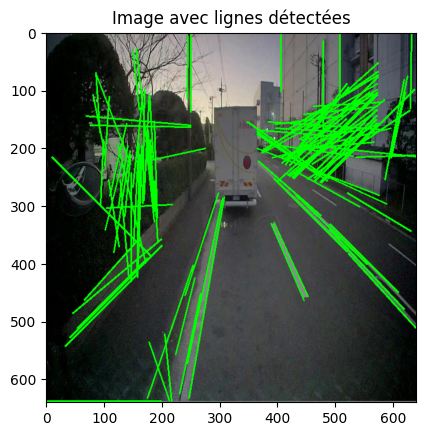

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger l'image
image_path = image_path_1 
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Égalisation d'histogramme (optionnelle pour améliorer le contraste)
equalized_image = cv2.equalizeHist(gray_image)

# Appliquons le filtre de Canny pour détecter les bords
edges = cv2.Canny(equalized_image, 50, 200, apertureSize=3)

# Utilisation de la transformée de Hough probabiliste pour détecter les lignes dans l'image
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)

# Trouvons les intersections des lignes pour calculer le point de fuite
intersections = []
if lines is not None:
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            intersections.append((x1, y1))
            intersections.append((x2, y2))

# Affichage de l'image originale avec les lignes détectées
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image avec lignes détectées')
plt.show()


On pourrait réaujuster les paramètres et appliquer quelques filtres (ignorer les lignes avec un angle horizontal par exemple) afin de ne détecter que les lignes intéressantes et maximiser la chance de trouver le point de fuite idéal. Mais pour ce premier essai, nous avions décidé de ne travailler qu'avec les fonctions classiques d'OpenCV et tenter de nous rapprocher le plus possible du point de fuite en ajustant au minimum les paramètres pour notre cas d'usage.

### **Clustering appliqué pour détecter le point de fuite :** 

Lorsqu'on détecte des segments de ligne dans une image, les points terminaux de ces segments sont souvent proches de là où ces lignes, si elles étaient prolongées à l'infini, se rencontreraient. On décide alors de calculer la moyenne de ces points pour approximer d'une manière grossière le point de fuite réel et voici pourquoi :

- Convergence des Lignes : Même si chaque segment de ligne détecté ne s'étend pas jusqu'au point de fuite réel, les extrémités des segments sont plus proches de ce point que d'autres parties des lignes. En moyenne, ils pointent tous vers le point de fuite.

- Effet de la Moyenne : Prendre la moyenne de ces points terminaux (calcul du centroïde des points) est une façon de trouver le "centre de masse" de ces indications. Si les lignes sont correctement détectées et si elles représentent des caractéristiques qui convergent effectivement vers un point de fuite, alors leur centroïde sera une estimation raisonnable de ce point.

- Filtrage du Bruit : En utilisant la moyenne, on minimise l'effet du bruit et des erreurs de détection individuelles. Chaque ligne peut être affectée par des facteurs tels que les ombres, les interruptions dans les marquages au sol, ou des erreurs dans l'algorithme de détection des lignes. La moyenne aide à "lisser" ces erreurs, donnant une estimation plus stable où la majorité des lignes semble converger.

#### Cas n°1 : Clustering sur l'ensemble des points

c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


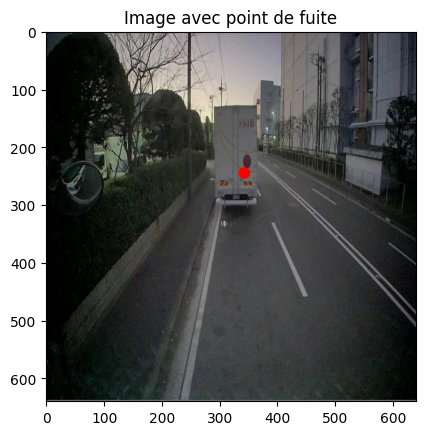

In [16]:
from sklearn.cluster import KMeans
import cv2
import matplotlib.pyplot as plt

# Nombre de cluster fixé à 1 pour ne trouver qu'un seul point de fuite
kmeans = KMeans(n_clusters=1, random_state=0).fit(intersections)

# Le centre du cluster représente le point de fuite
vanishing_point = kmeans.cluster_centers_

# Chargeons notre image originale
image_path = image_path_1
image = cv2.imread(image_path)

# Dessinons le point de fuite sur l'image
cv2.circle(image, (int(vanishing_point[0][0]), int(vanishing_point[0][1])), 10, (0, 0, 255), -1)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image avec point de fuite')
plt.show()


Calculons l'erreur de calcul en utilisant la distance euclidienne (l'erreur est exprimée en pixel): 

In [17]:
error = np.sqrt((vanishing_point[0][0] - ground_truth_vp[0]) ** 2 + (vanishing_point[0][1] - ground_truth_vp[1]) ** 2)
error

61.999790055629575

Dans une image de 640x640, une erreur de 61.99 pixels peut être considérée comme significative. Pour avoir un contexte, si on trace un cercle avec un rayon de 61.99 pixels sur l'image, le point de fuite détecté pourrait se trouver n'importe où sur le périmètre de ce cercle par rapport au point de fuite réel.

Visuellement, cela pourrait être interprété comme une déviation notable du point où les lignes semblent converger. Sur une route, cela pourrait affecter la perception de la direction ou la trajectoire.

#### Cas n°2 : Clustering sur l'ensemble des points 'proches' du point de fuite :

Déterminer quelle extrémité est "la plus proche" du point de fuite n'est pas toujours trivial sans calculer réellement les intersections ou sans avoir une analyse approfondie de l'orientation et de la pente de chaque ligne par rapport à l'ensemble de la scène. Dans notre cas 'Images de route' le point de fuite semble toujours plus proche de l'extrémité la plus haute, nous allons alors modifier notre approche et tester notre hypothèse : 

c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


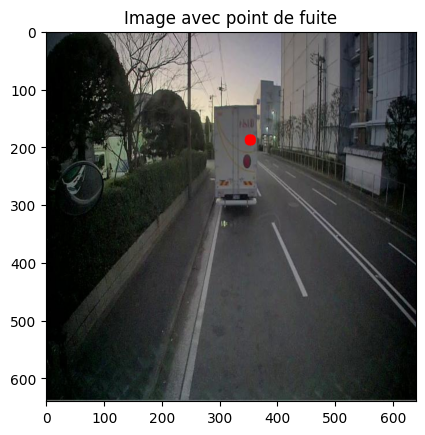

In [18]:
# Trouvons les intersections des lignes pour calculer le point de fuite
intersections = []
if lines is not None:
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Sélectionner le point avec le plus grand 'y'
            if y1 > y2:
                intersections.append((x2, y2)) #L'axe des ordonnées est inversé             
            else:
                intersections.append((x1, y1))

# Nombre de cluster fixé à 1 pour ne trouver qu'un seul point de fuite
kmeans = KMeans(n_clusters=1, random_state=0).fit(intersections)

# Le centre du cluster représente le point de fuite
vanishing_point = kmeans.cluster_centers_

# Chargeons notre image originale
image_path = image_path_1
image = cv2.imread(image_path)

# Dessinons le point de fuite sur l'image
cv2.circle(image, (int(vanishing_point[0][0]), int(vanishing_point[0][1])), 10, (0, 0, 255), -1)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image avec point de fuite')
plt.show()



Calculons l'erreur à nouveau :

In [19]:
error = np.sqrt((vanishing_point[0][0] - ground_truth_vp[0]) ** 2 + (vanishing_point[0][1] - ground_truth_vp[1]) ** 2)
error

25.249885033696145

Nous avons réussi à réduire l'erreur plus que par deux, notre hypothèse était valable dans ce cas (Un cas assez simple avec peu de perturbations et avec une route bien marquée), nous pourrions même envisage de prétraiter l'image encore plus avant de calculer le point de fuite pour ne garder que les extrémités intéressantes (notemment via une segmentation au préalable, éliminer les lignes horizontales, ...).

Essayons maintenant de voir la moyenne des erreurs sur un ensemble des images de notre dataset :

In [30]:
import os

dataset_directory = 'C:/Users/Maamar/Desktop/VanishingPointDetection_CS/Road_Annotated_Dataset/train'

all_files = os.listdir(dataset_directory)

# On filtre les fichiers pour n'obtenir que les images non annotées
image_paths = [os.path.join(dataset_directory, file) for file in all_files if not file.endswith('_mask.png')]

# Associons chaque image à son masque
mask_paths = [os.path.join(dataset_directory, file.replace('.jpg', '_mask.png')) for file in image_paths]

# Vérifions que chaque image et son masque existent
image_mask_pairs = list(zip(image_paths, mask_paths))
image_mask_pairs = [(img, mask) for img, mask in image_mask_pairs if os.path.exists(img) and os.path.exists(mask)]

# Maintenant, image_mask_pairs contient des paires de chemins d'images et de masques


In [29]:
image_mask_pairs

[('C:/Users/Maamar/Desktop/VanishingPointDetection_CS/Road_Annotated_Dataset/train\\112_png.rf.4d7f570fe2a7ed4c79790fe205736fbf.jpg',
  'C:/Users/Maamar/Desktop/VanishingPointDetection_CS/Road_Annotated_Dataset/train\\112_png.rf.4d7f570fe2a7ed4c79790fe205736fbf_mask.png'),
 ('C:/Users/Maamar/Desktop/VanishingPointDetection_CS/Road_Annotated_Dataset/train\\113_png.rf.0671801cb7337785bc2af0c01e80298b.jpg',
  'C:/Users/Maamar/Desktop/VanishingPointDetection_CS/Road_Annotated_Dataset/train\\113_png.rf.0671801cb7337785bc2af0c01e80298b_mask.png'),
 ('C:/Users/Maamar/Desktop/VanishingPointDetection_CS/Road_Annotated_Dataset/train\\116_png.rf.39529d8942d258c27bea4a469b0aa4ce.jpg',
  'C:/Users/Maamar/Desktop/VanishingPointDetection_CS/Road_Annotated_Dataset/train\\116_png.rf.39529d8942d258c27bea4a469b0aa4ce_mask.png'),
 ('C:/Users/Maamar/Desktop/VanishingPointDetection_CS/Road_Annotated_Dataset/train\\117_png.rf.c7db5b631ad27da83586054aab9a4651.jpg',
  'C:/Users/Maamar/Desktop/VanishingPointDet

Fonction pour extraire le point de fuite du masque

In [31]:
def extract_ground_truth_vp(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    vp_pixels = np.where(mask == 4)  # '4' est la valeur annotée pour le point de fuite
    if len(vp_pixels[0]) > 0 and len(vp_pixels[1]) > 0:
        vp_x = np.mean(vp_pixels[1])
        vp_y = np.mean(vp_pixels[0])
        return (int(vp_x), int(vp_y))
    return None

Fonction pour détecter le point de fuite à partir de l'image

In [32]:
def detect_vanishing_point(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Égalisation d'histogramme (optionnelle pour améliorer le contraste)
    equalized_image = cv2.equalizeHist(gray_image)

    # Appliquons le filtre de Canny pour détecter les bords
    edges = cv2.Canny(equalized_image, 50, 200, apertureSize=3)

    # Utilisation de la transformée de Hough probabiliste pour détecter les lignes dans l'image
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)
    # Trouvons les intersections des lignes pour calculer le point de fuite
    intersections = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                # Sélectionner le point avec le plus grand 'y'
                if y1 > y2:
                    intersections.append((x2, y2)) #L'axe des ordonnées est inversé             
                else:
                    intersections.append((x1, y1))

    # Nombre de cluster fixé à 1 pour ne trouver qu'un seul point de fuite
    kmeans = KMeans(n_clusters=1, random_state=0).fit(intersections)

    # Le centre du cluster représente le point de fuite
    vanishing_point = kmeans.cluster_centers_
    return vanishing_point

Fonction pour calculer l'erreur : 

In [33]:
def calculate_error(vp1, vp2):
    return np.sqrt((vp1[0] - vp2[0][0]) ** 2 + (vp1[1] - vp2[0][1]) ** 2)


On boucle sur le dataset, on applique les fonctions et on calcule l'erreur moyenne

In [34]:
errors = []
for image_path, mask_path in image_mask_pairs:
    gt_vp = extract_ground_truth_vp(mask_path)
    detected_vp = detect_vanishing_point(image_path)
    if gt_vp is not None and detected_vp is not None:
        error = calculate_error(gt_vp, detected_vp)
        errors.append(error)

# Calculer l'erreur moyenne
mean_error = np.mean(errors)
print("Erreur moyenne sur le dataset :", mean_error)


c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\

Erreur moyenne sur le dataset : 110.61368861020419


c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Une erreur moyenne de 110 est très significative, revenons à l'hypothèse de départ et calculons l'erreur moyenne : 

In [37]:
def detect_vanishing_point_2(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Égalisation d'histogramme (optionnelle pour améliorer le contraste)
    equalized_image = cv2.equalizeHist(gray_image)

    # Appliquons le filtre de Canny pour détecter les bords
    edges = cv2.Canny(equalized_image, 50, 200, apertureSize=3)

    # Utilisation de la transformée de Hough probabiliste pour détecter les lignes dans l'image
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)
    # Trouvons les intersections des lignes pour calculer le point de fuite
    intersections = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                intersections.append((x1, y1))
                intersections.append((x2, y2))

    # Nombre de cluster fixé à 1 pour ne trouver qu'un seul point de fuite
    kmeans = KMeans(n_clusters=1, random_state=0).fit(intersections)

    # Le centre du cluster représente le point de fuite
    vanishing_point = kmeans.cluster_centers_
    return vanishing_point

In [38]:
errors = []
for image_path, mask_path in image_mask_pairs:
    gt_vp = extract_ground_truth_vp(mask_path)
    detected_vp = detect_vanishing_point_2(image_path)
    if gt_vp is not None and detected_vp is not None:
        error = calculate_error(gt_vp, detected_vp)
        errors.append(error)

# Calculer l'erreur moyenne
mean_error = np.mean(errors)
print("Erreur moyenne sur le dataset :", mean_error)

c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\

Erreur moyenne sur le dataset : 138.49773428686765


c:\Users\Maamar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Calcul de l'erreur de calcul du VP : 

## **3D Reconstruction using single view image**

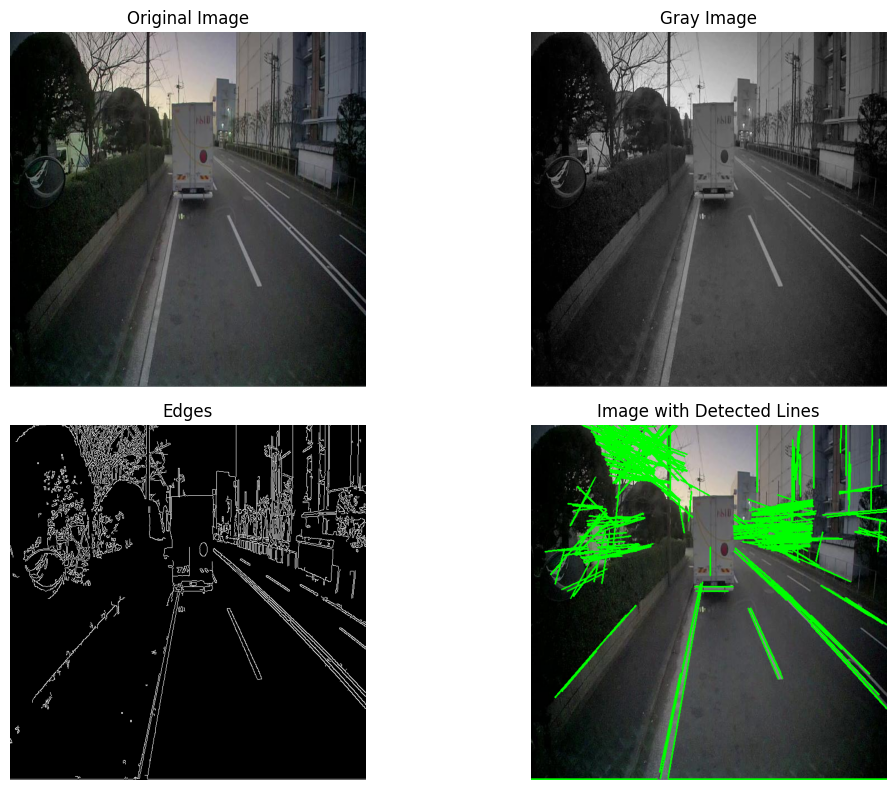

In [6]:
# Load the image
image_path = image_path_1
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Edge detection using Canny
edges = cv2.Canny(gray_image, 50, 200, apertureSize=3)

# Detect line segments using the Hough Transform
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

# Create a subplot with 2 rows and 2 columns
plt.figure(figsize=(12, 8))

# Original Image
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Gray Image
plt.subplot(2, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.title('Gray Image')
plt.axis('off')

# Edges
plt.subplot(2, 2, 3)
plt.imshow(edges, cmap='gray')
plt.title('Edges')
plt.axis('off')

# Lines on Original Image
image_with_lines = image.copy()
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
plt.title('Image with Detected Lines')
plt.axis('off')

plt.tight_layout()
plt.show()


Clusterization of line segments :

Function calculating orientation of segments : 

In [7]:
import numpy as np

def calculate_orientation(x1, y1, x2, y2):
    """
    Calculate the orientation of a line segment.
    """
    return np.arctan2(y2 - y1, x2 - x1) * (180 / np.pi)


Clustering algorithm :

In [8]:
def cluster_line_segments(lines):
    """
    Cluster line segments based on their orientation.
    """
    orientations = [calculate_orientation(x1, y1, x2, y2) for x1, y1, x2, y2 in lines]
    # For simplicity, let's categorize orientations into bins
    # This is a naive approach; for real applications, consider using clustering algorithms like DBSCAN
    bins = np.linspace(-90, 90, 3)  # 10 bins for example
    digitized = np.digitize(orientations, bins)
    clusters = {}
    for i, bin_num in enumerate(digitized):
        if bin_num not in clusters:
            clusters[bin_num] = []
        clusters[bin_num].append(lines[i])
    return clusters


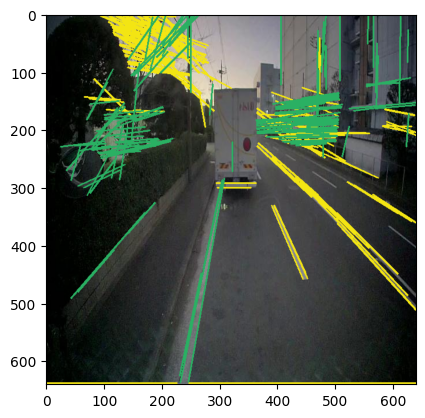

In [9]:
# Prepare lines format and cluster them
lines_format = [line[0] for line in lines]  # Convert to a simpler format
clusters = cluster_line_segments(lines_format)

# Visualize the clusters
for bin_num, cluster_lines in clusters.items():
    color = tuple(np.random.randint(0, 255, 3).tolist())  # Random color for each cluster
    for x1, y1, x2, y2 in cluster_lines:
        cv2.line(image, (x1, y1), (x2, y2), color, 2)

#cv2.imshow('Clustered Line Segments', image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))